In [1]:
# %pip install grad-cam

In [2]:
# Some parameters
img_size = 224
num_classes = 200

In [3]:
import torch
from torchvision.models import vgg16

device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.

model = vgg16(num_classes=num_classes)  # Initialize the VGG16 model
model = torch.nn.DataParallel(model)
model = model.cuda()

# Load the checkpoint
pretrained_model_path = "vgg16_finetuned.pth/model_best.pth.tar"
checkpoint = torch.load(pretrained_model_path)

# Remove 'module.' prefix
state_dict = checkpoint['state_dict']

# Load the modified state dict
model.load_state_dict(state_dict)

# Let it be the module in order for it to match the pytorch_grad_cam package
model = model.module

<All keys matched successfully>

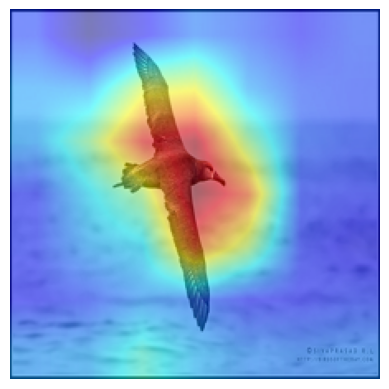

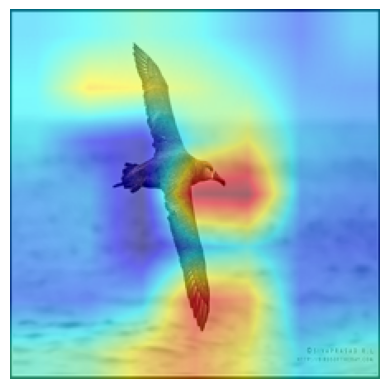

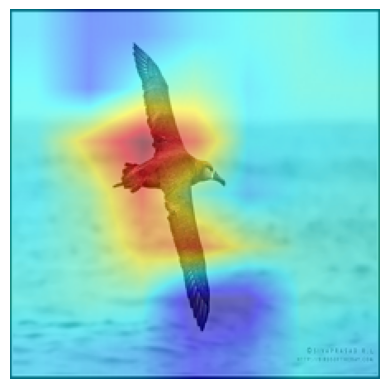

In [6]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

target_layers = [model.features[-1]]
IMAGE_PATH = "../CUB_200_2011/val/001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg"
image = Image.open(IMAGE_PATH)

resized_image = image.resize((img_size, img_size))

# Convert the image to a numpy array
image_array = np.array(resized_image)

# Normalize the image array to be in the range [0, 1]
rgb_img = image_array.astype(np.float32) / 255.0

# # Display the image
# plt.imshow(image)
# plt.axis('on')  # Turn off axis labels
# plt.show()


normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(img_size),
          transforms.ToTensor(),
          normalize,
      ])
input_tensor = transform(image).unsqueeze(0).to(device)

# Enter evaluation mode
model.eval()

model(input_tensor)


#input_tensor = # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
targets = [ClassifierOutputTarget(0)]
#targets = [ClassifierOutputSoftmaxTarget(0)]

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Display the image
plt.imshow(visualization)
plt.axis('off')  # Turn off axis labels
plt.show()

targets = [ClassifierOutputTarget(71)]
#targets = [ClassifierOutputSoftmaxTarget(0)]

grayscale_cam2 = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam2 = grayscale_cam2[0, :]
visualization2 = show_cam_on_image(rgb_img, grayscale_cam2, use_rgb=True)

# Display the image
plt.imshow(visualization2)
plt.axis('off')  # Turn off axis labels
plt.show()

diff_cam = grayscale_cam-grayscale_cam2
diff_cam = np.interp(diff_cam, (diff_cam.min(), diff_cam.max()), (0, 1))

visualization3 = show_cam_on_image(rgb_img, diff_cam, use_rgb=True)
# Display the image
plt.imshow(visualization3)
plt.axis('off')  # Turn off axis labels
plt.show()



In [7]:
# linear_activations = None

# def get_linear_activations(module, input, output):
#     global linear_activations
#     linear_activations = output.detach()

# hook_handle = model.classifier[6].register_forward_hook(get_linear_activations)
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# #model(input_tensor)
# hook_handle.remove()
# softmax = torch.nn.Softmax(dim=1)
# softmax(linear_activations) # This is softmax.


In [8]:
def get_explanations(IMAGE_PATH):
    target_layers = [model.features[-1]]
    image = Image.open(IMAGE_PATH)
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([
              transforms.Resize(256),
              transforms.CenterCrop(img_size),
              transforms.ToTensor(),
              normalize,
          ])
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    global linear_activations
    linear_activations = None

    def get_linear_activations(module, input, output):
        global linear_activations
        linear_activations = output.detach()

    hook_handle = model.classifier[6].register_forward_hook(get_linear_activations)
    model(input_tensor)
    hook_handle.remove()
    logits = linear_activations

    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    camms = []
    
    # This is extremely inefficient, should be enough with just one forward pass
    for i in range(num_classes):
        targets = [ClassifierOutputTarget(i)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        camms.append(grayscale_cam)
        
    return np.array(camms), logits
        


In [9]:
explanation_vectors, logits = get_explanations(IMAGE_PATH)

In [10]:
def min_max_normalize(np_arr):
    return np.interp(np_arr, (np_arr.min(), np_arr.max()), (0, 1))

In [11]:
# Give us some contrastive SHIT!

#explanation_vector = explanation_vectors

def mean_contrast(explanation_vectors, target):
    # Shape of explanation vectors should be (C, ...) where C is the number of classes
    target_explanation = explanation_vectors[target]
    mask = np.arange(explanation_vectors.shape[0]) != target
    mean_explanation_excluding_target = explanation_vectors[mask].mean(axis=0)
    explanation = target_explanation - mean_explanation_excluding_target
    
    return min_max_normalize(explanation)

def max_contrast(explanation_vectors, target, logits):
    # Shape of explanation vectors should be (C, ...) where C is the number of classes
    _, inds = torch.topk(logits, 2, dim=1)

    inds = inds[0]
    print(inds[1])
    ind = inds[0] if inds[0] != target else inds[1]
    
    explanation = explanation_vectors[target] - explanation_vectors[ind]
    
    return min_max_normalize(explanation)
    
def weighted_contrast(explanation_vectors, target, logits):
    # Shape of explanation vectors should be (C, ...) where C is the number of classes
    
    # This is very inefficient
    logits_cp = logits.detach().clone()
    logits_cp[0][target] = float("-inf")
    alphas = torch.nn.functional.softmax(logits_cp, dim=1).cpu().numpy()
    #alphas = np.array(alphas)

    explanation = np.zeros_like(explanation_vectors[0])

    # Iterate over each class and its corresponding weight
    for i, (explanation_vector, alpha) in enumerate(zip(explanation_vectors, alphas[0])):
        if i != target:
            explanation -= alpha * explanation_vector
        else:
            explanation += explanation_vector
            
    return min_max_normalize(explanation)


(224, 224)
float64


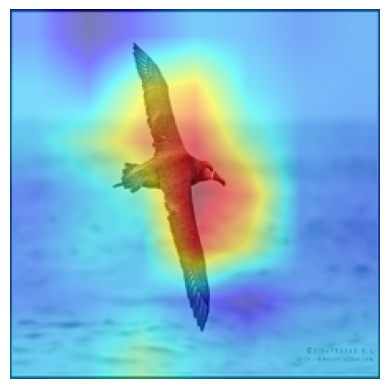

In [12]:
mc = mean_contrast(explanation_vectors, 0)[0,:]
print(mc.shape)
print(mc.dtype)

visualization = show_cam_on_image(rgb_img, mc, use_rgb=True)

# Display the image
plt.imshow(visualization)
plt.axis('off')  # Turn off axis labels
plt.show()


tensor(71, device='cuda:0')


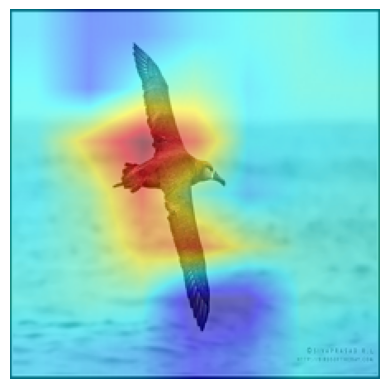

In [13]:
mxc = max_contrast(explanation_vectors, 0, logits)[0,:]

visualization = show_cam_on_image(rgb_img, mxc, use_rgb=True)

# Display the image
plt.imshow(visualization)
plt.axis('off')  # Turn off axis labels
plt.show()

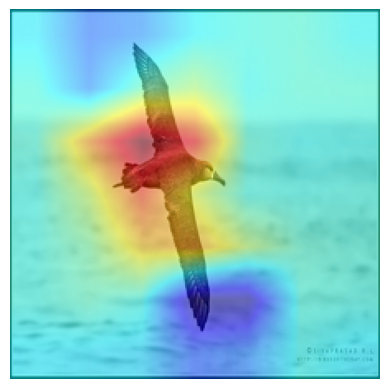

In [14]:
wc = weighted_contrast(explanation_vectors, 0, logits)[0,:]

visualization = show_cam_on_image(rgb_img, wc, use_rgb=True)

# Display the image
plt.imshow(visualization)
plt.axis('off')  # Turn off axis labels
plt.show()